<a href="https://colab.research.google.com/github/swapnilmn/Assignment_1-CS6910/blob/master/Question_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries 

In [ ]:
from keras.datasets import fashion_mnist, mnist
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
from sklearn.model_selection import train_test_split 
import pickle
import pandas as pd
import os
from tqdm import tqdm_notebook 
from sklearn.preprocessing import OneHotEncoder

<ipython-input-12-b5df203cd1cb>:109: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2 [00:00<?, ?epoch/s]

0.0989074074074074
0.1454074074074074


<ipython-input-12-b5df203cd1cb>:253: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  confusion_matrix_ = np.zeros((len(available_classes),len(available_classes)),dtype=np.int)


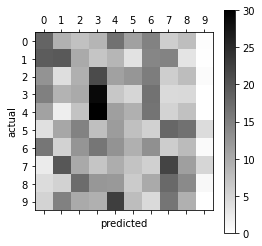

In [ ]:
class FFNetwork:
  def __init__(self, X, Y,
               epochs = 100, 
               no_hidden_layers = 4,
               hidden_layers =  [32, 64, 128, 256],
               learning_rate = 0.001,
               batch_size = 32,
               activation='tanh',
               weight_init='random',
               loss = 'MSE'):
    
    self.nx =X.shape[1] # Number of inputs
    self.ny= Y.shape[1] # Number of outputs
    self.epochs = epochs
    self.nh = no_hidden_layers  # Number of hidden layers 
    self.sizes= [self.nx] + hidden_layers +[self.ny] # input layer + hidden layers + output layers
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.params={} # It will create dictionary for weights and biases
    self.params_h = []
    self.num_classes = Y.shape[1]
    self.weight_init = weight_init
    self.activation_function = activation
    self.loss_function = loss
    self.lambd = 0
    np.random.seed(0)  # We will set seed value so that it will generate same random numebers every time

    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.nh+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
    
    if self.weight_init == "random":
      for i in range(1,self.nh+2):
        self.params["W"+str(i)] = np.random.randn(self.sizes[i-1],self.sizes[i])
        self.params["B"+str(i)] = np.random.randn(1,self.sizes[i])
    
    elif self.weight_init == "Xavier":
      for i in range(1,self.nh+2):
        self.params["W"+str(i)]=np.random.randn(self.sizes[i-1],self.sizes[i])*np.sqrt(1/self.sizes[i-1])
        self.params["B"+str(i)]=np.random.randn(1,self.sizes[i])

  
  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "Relu":
      return np.maximum(0,X)

  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X) 
    elif self.activation_function == "tanh":
      return (1-np.square(X))
    elif self.activation_function == "Relu":
      return 1.0*(X>0)

  def softmax(self, X):
    exps =np.exp(X - np.max(X, axis=1, keepdims=True))
    return  exps /np.sum(exps, axis=1, keepdims=True)
  
  def forward_pass(self,X, params=None):
    if params is None:
        params = self.params
    self.A ={}
    self.H ={}
    self.H[0] = X
    for i in range(self.nh):
        self.A[i+1] =np.matmul(self.H[i], params[f"W{i+1}"]) + params[f"B{i+1}"]
        self.H[i+1] = self.forward_activation(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh],params[f"W{self.nh+1}"]) +params[f"B{self.nh+1}"]
    self.H[self.nh+1] =self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def grad(self, X, Y, params=None):
    if params is None:
        params = self.params

    self.forward_pass(X, params)
    self.gradients = {}
    L = self.nh + 1

    if self.loss_function == 'CE':
        self.gradients[f"dA{L}"] = (self.H[L] - Y) * (1/X.shape[0])
    elif self.loss_function == 'MSE':
        self.gradients[f"dA{L}"] = (1/X.shape[0]) * 2 * (self.H[L] - Y)

    for k in range(L, 0, -1):
        self.gradients[f"dW{k}"] = np.matmul(self.H[k-1].T, self.gradients[f"dA{k}"]) + self.lambd * params[f"W{k}"]
        self.gradients[f"dB{k}"] = np.sum(self.gradients[f"dA{k}"], axis=0).reshape(1, -1)
        self.gradients[f"dH{k-1}"] = np.matmul(self.gradients[f"dA{k}"], params[f"W{k}"].T)
        self.gradients[f"dA{k-1}"] = np.multiply(self.gradients[f"dH{k-1}"], self.grad_activation(self.H[k-1]))

    return self.gradients[f"dH{k-1}"]
  
  def fit(self, X, Y,algo= "GD", eps=1e-8, beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
    
    eta = self.learning_rate
    mini_batch_size = self.batch_size
    epochs = self.epochs
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      #m = X.shape[0]

      
      if algo == "GD":
        self.grad(X, Y)
        for i in range(1,self.nh+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)])
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)])
        print(self.accuracy_score(X, Y))
          
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1,self.nh+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)])
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)])
        print(self.accuracy_score(X, Y))
            

model = FFNetwork(X_train, Y_train,
                  epochs = 2, 
                  no_hidden_layers = 4,
                  hidden_layers =  [32, 64, 128, 256],
                  learning_rate = 0.001,
                  batch_size = 32,
                  activation='tanh',
                  weight_init='random',
                  loss = 'MSE')
model.fit(X_train, Y_train, algo= "Nadam")


confusion matrix

[[820   2   9  59   3   6  86   0  14   1]
 [  5 942  13  32   5   0   1   0   2   0]
 [ 21   1 694   9 149   1 111   0  14   0]
 [ 30  13   3 858  33   1  57   0   4   1]
 [  1   1 102  38 751   0 100   0   7   0]
 [  1   0   0   2   0 881   0  68   8  40]
 [186   2 118  41 119   2 504   0  28   0]
 [  0   0   0   0   0  54   0 871   0  75]
 [  0   1  14  12   3  13  20   3 932   2]
 [  0   0   0   0   0  21   0  51   1 927]]


<ipython-input-46-5da8501de650>:233: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  confusion_matrix_ = np.zeros((len(available_classes),len(available_classes)),dtype=np.int)


0.818

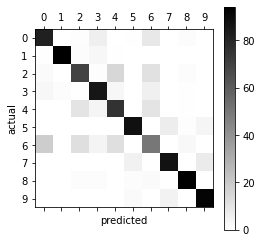

In [ ]:
test_prediction = np.argmax(model.forward_pass(X_test), axis=1)
test_accuracy = model.accuracy_score(X_test, Y_test)


  # confusion matrix
print("\nconfusion matrix\n")
y_actual = pd.Series(np.argmax(Y_test, axis = 1), name='Actual')
y_prediction = pd.Series(test_prediction, name='Predicted')
confusion_matrix = model.confusion_matrix(y_actual, y_prediction)
print(confusion_matrix)
model.confusion_matrix_plot(confusion_matrix)
model.accuracy_score(X_test, Y_test)

0        5
1        2
2        9
3        0
4        5
        ..
53995    2
53996    0
53997    6
53998    6
53999    1
Name: Actual, Length: 54000, dtype: int64